# Make all oxidative ratio uncertainty figures

In [1]:
import os
import glob
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta

from acrg.name import name
from acrg.obs import get_obs
from acrg.obs import get_single_site

import apo_emiss_func, apo_funcs, apo_plot_info

/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
sigma = 3
fontsize = 16

site = 'WAO'
year = 2015
months = [8, 12]

ocean_model = 'nemo'
ff_model = 'edgar-ukghg'
or_ff_model = 'gridfed-ukghg'

date_strs = {month: f'{year}{str(month).zfill(2)}' for month in months}
start_dates = {month: datetime(year, month, 1) for month in months}
end_dates = {month: start_date + relativedelta(months=1, seconds=-1) for month, start_date in start_dates.items()}

or_ff_model = 'gridfed' if ff_model=='edgar' else or_ff_model

## Get the obs

We plot the obs on all APO figures for easy comparison

In [3]:
apo_obs = {month: get_obs([site], 'APO', start_date, end_dates[month], keep_missing=True)
           for month, start_date in start_dates.items()}

Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20221215.nc
... slicing from 2015-08-01 00:00:00 to 2015-08-31 23:59:58.999999999
Assuming status flag = 0 for all sites
Getting APO data for WAO...
... reading /group/chemistry/acrg/obs/WAO/UEA-Oxzilla_WAO_20100519_APO-20221215.nc
... slicing from 2015-12-01 00:00:00 to 2015-12-31 23:59:58.999999999


/user/home/vf20487/.conda/envs/acrg/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'rasterio' loading failed:
libLerc.so.4: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## Get the timeseries data

In [4]:
ts_data = apo_funcs.get_timeseries(sites = [site],
                                   year = year,
                                   sources = ['bc', 'ff', 'ocean'])
ts_data = {month: ts_data[site].sel(time=slice(start, end_dates[month]))
           for month, start in start_dates.items()}

for month, ts_month in ts_data.items():
    ts_data[month]['apo_bc'] = ts_month.apo_bc - apo_plot_info.adjust[year][site][month]

Finding timeseries for WAO
bc: ['/user/work/vf20487/Timeseries/o2_co2/WAO_bc_timeseries_2015.nc']
ff: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ff_timeseries_2015.nc']
ocean: ['/user/work/vf20487/Timeseries/o2_co2/WAO_ocean_timeseries_2015.nc']

Dropping variables: 
['delta_o2_n2_bc', 'co2_ocean_ecco_mth', 'o2_ocean_ecco_mth', 'co2_ocean_nemo_mth', 'o2_ocean_nemo_mth']

Data variables: 
['co2_ff', 'apo_bc', 'co2_bc', 'o2_bc', 'apo_adjusted_bc', 'o2_ff', 'co2_ocean_ecco', 'o2_ocean_ecco', 'co2_ocean_jena', 'o2_ocean_jena', 'co2_ocean_nemo', 'o2_ocean_nemo', 'n2_ocean_nemo']
---------------------------



### Calculate the total APO model

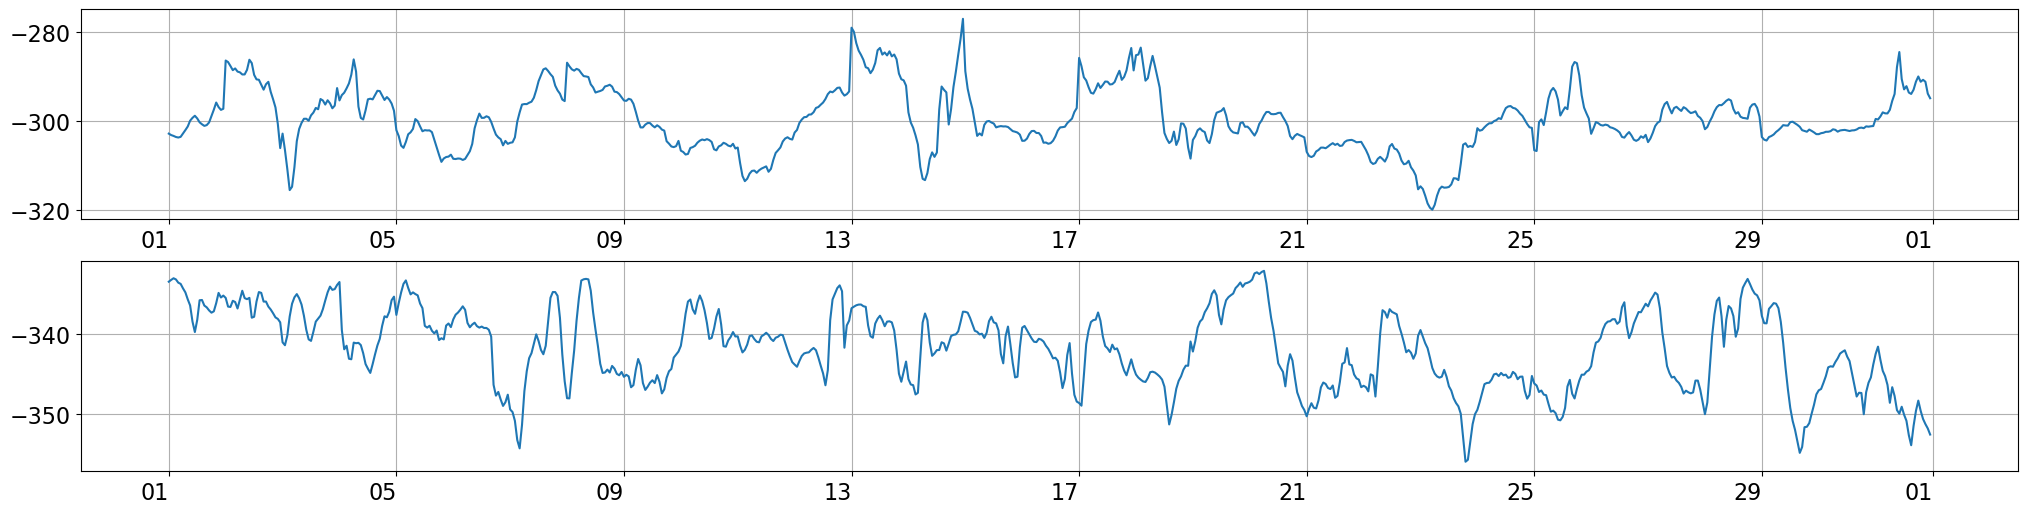

In [6]:
apo_total = {month: {ocean_sim: apo_emiss_func.apo(ocean_o2 = ts_month[f'o2_ocean_{ocean_sim}'],
                                                   ocean_co2 = ts_month[f'co2_ocean_{ocean_sim}'],
                                                   ff_co2 = ts_month.co2_ff,
                                                   ff_o2 = ts_month.o2_ff,
                                                   ocean_n2 = ts_month.n2_ocean_nemo,
                                                   convert = False) + ts_data[month].apo_adjusted_bc
                     for ocean_sim in ['ecco', 'jena', 'nemo']}
             for month, ts_month in ts_data.items()}

fig, axes = plt.subplots(nrows=len(months), ncols=1, figsize=(25, 3*len(months)))
lines = [apo_month['nemo'].plot(ax=axes[mm]) for mm, apo_month in enumerate(apo_total.values())]
ylabels = [ax.set_xlabel('') for ax in axes]
grid = [ax.grid() for ax in axes]
myFmt = mdates.DateFormatter('%d')
[ax.xaxis.set_major_formatter(myFmt) for ax in axes]
ticks = [ax.tick_params(labelsize=fontsize, labelrotation=0) for ax in axes]

## Get the uncertainties

Uncertainty analysis is run in a separate file, here we read in the results

In [7]:
path_unc = os.path.join('/user', 'work', 'vf20487', 'Sensitivities')
uncertainty_filenames = {month: glob.glob(os.path.join(path_unc, f'APO_unc*{date_str}.nc'))[0]
                         for month, date_str in date_strs.items()}
print(f'Uncertainty file: {uncertainty_filenames}')

data_unc = {month: name.open_ds(file_month) for month, file_month in uncertainty_filenames.items()}

# adjust the baseline of the APO model
# for month, data_month in data_unc.items():
#     data_unc[month][f'model_{ocean_model}'] = data_month[f'model_{ocean_model}'] - apo_plot_info.adjust[year][site][month]

Uncertainty file: {8: '/user/work/vf20487/Sensitivities/APO_uncertainties_201508.nc', 12: '/user/work/vf20487/Sensitivities/APO_uncertainties_201512.nc'}


In [7]:
for month, data_month in data_unc.items():
    print(f'Month: {month}')
    print(f'Bio oxidative ratio sensitivity: {(data_month[f"OR_bio_{ocean_model}"] / data_month[f"model_{ocean_model}"] * 100).values.mean()} per cent')
    print(f'Bio oxidative ratio average 1 sigma: {data_month[f"OR_bio_{ocean_model}"].values.mean()} per meg')
    print(f'FF oxidative ratio sensitivity: {(data_month[f"OR_ff_{ocean_model}"] / data_month[f"model_{ocean_model}"] * 100).values.mean()} per cent')
    print(f'FF oxidative ratio average 1 sigma: {data_month[f"OR_ff_{ocean_model}"].values.mean()} per meg')

Month: 8
Bio oxidative ratio sensitivity: -0.08461933303793312 per cent
Bio oxidative ratio average 1 sigma: 0.2678301512598925 per meg
FF oxidative ratio sensitivity: -0.09624275163166607 per cent
FF oxidative ratio average 1 sigma: 0.3041726152331717 per meg
Month: 12
Bio oxidative ratio sensitivity: -0.1211506966246552 per cent
Bio oxidative ratio average 1 sigma: 0.4111057184187511 per meg
FF oxidative ratio sensitivity: -0.15322791667393926 per cent
FF oxidative ratio average 1 sigma: 0.5224284190305108 per meg


## Plot the oxidative ratio uncertainties

Plotting 3 sigma uncertainty
Saving to /user/work/vf20487/Figures/Timeseries/Sensitivity/APO_timeseries_OR_sensitivity_3sigma_201508-201512.png


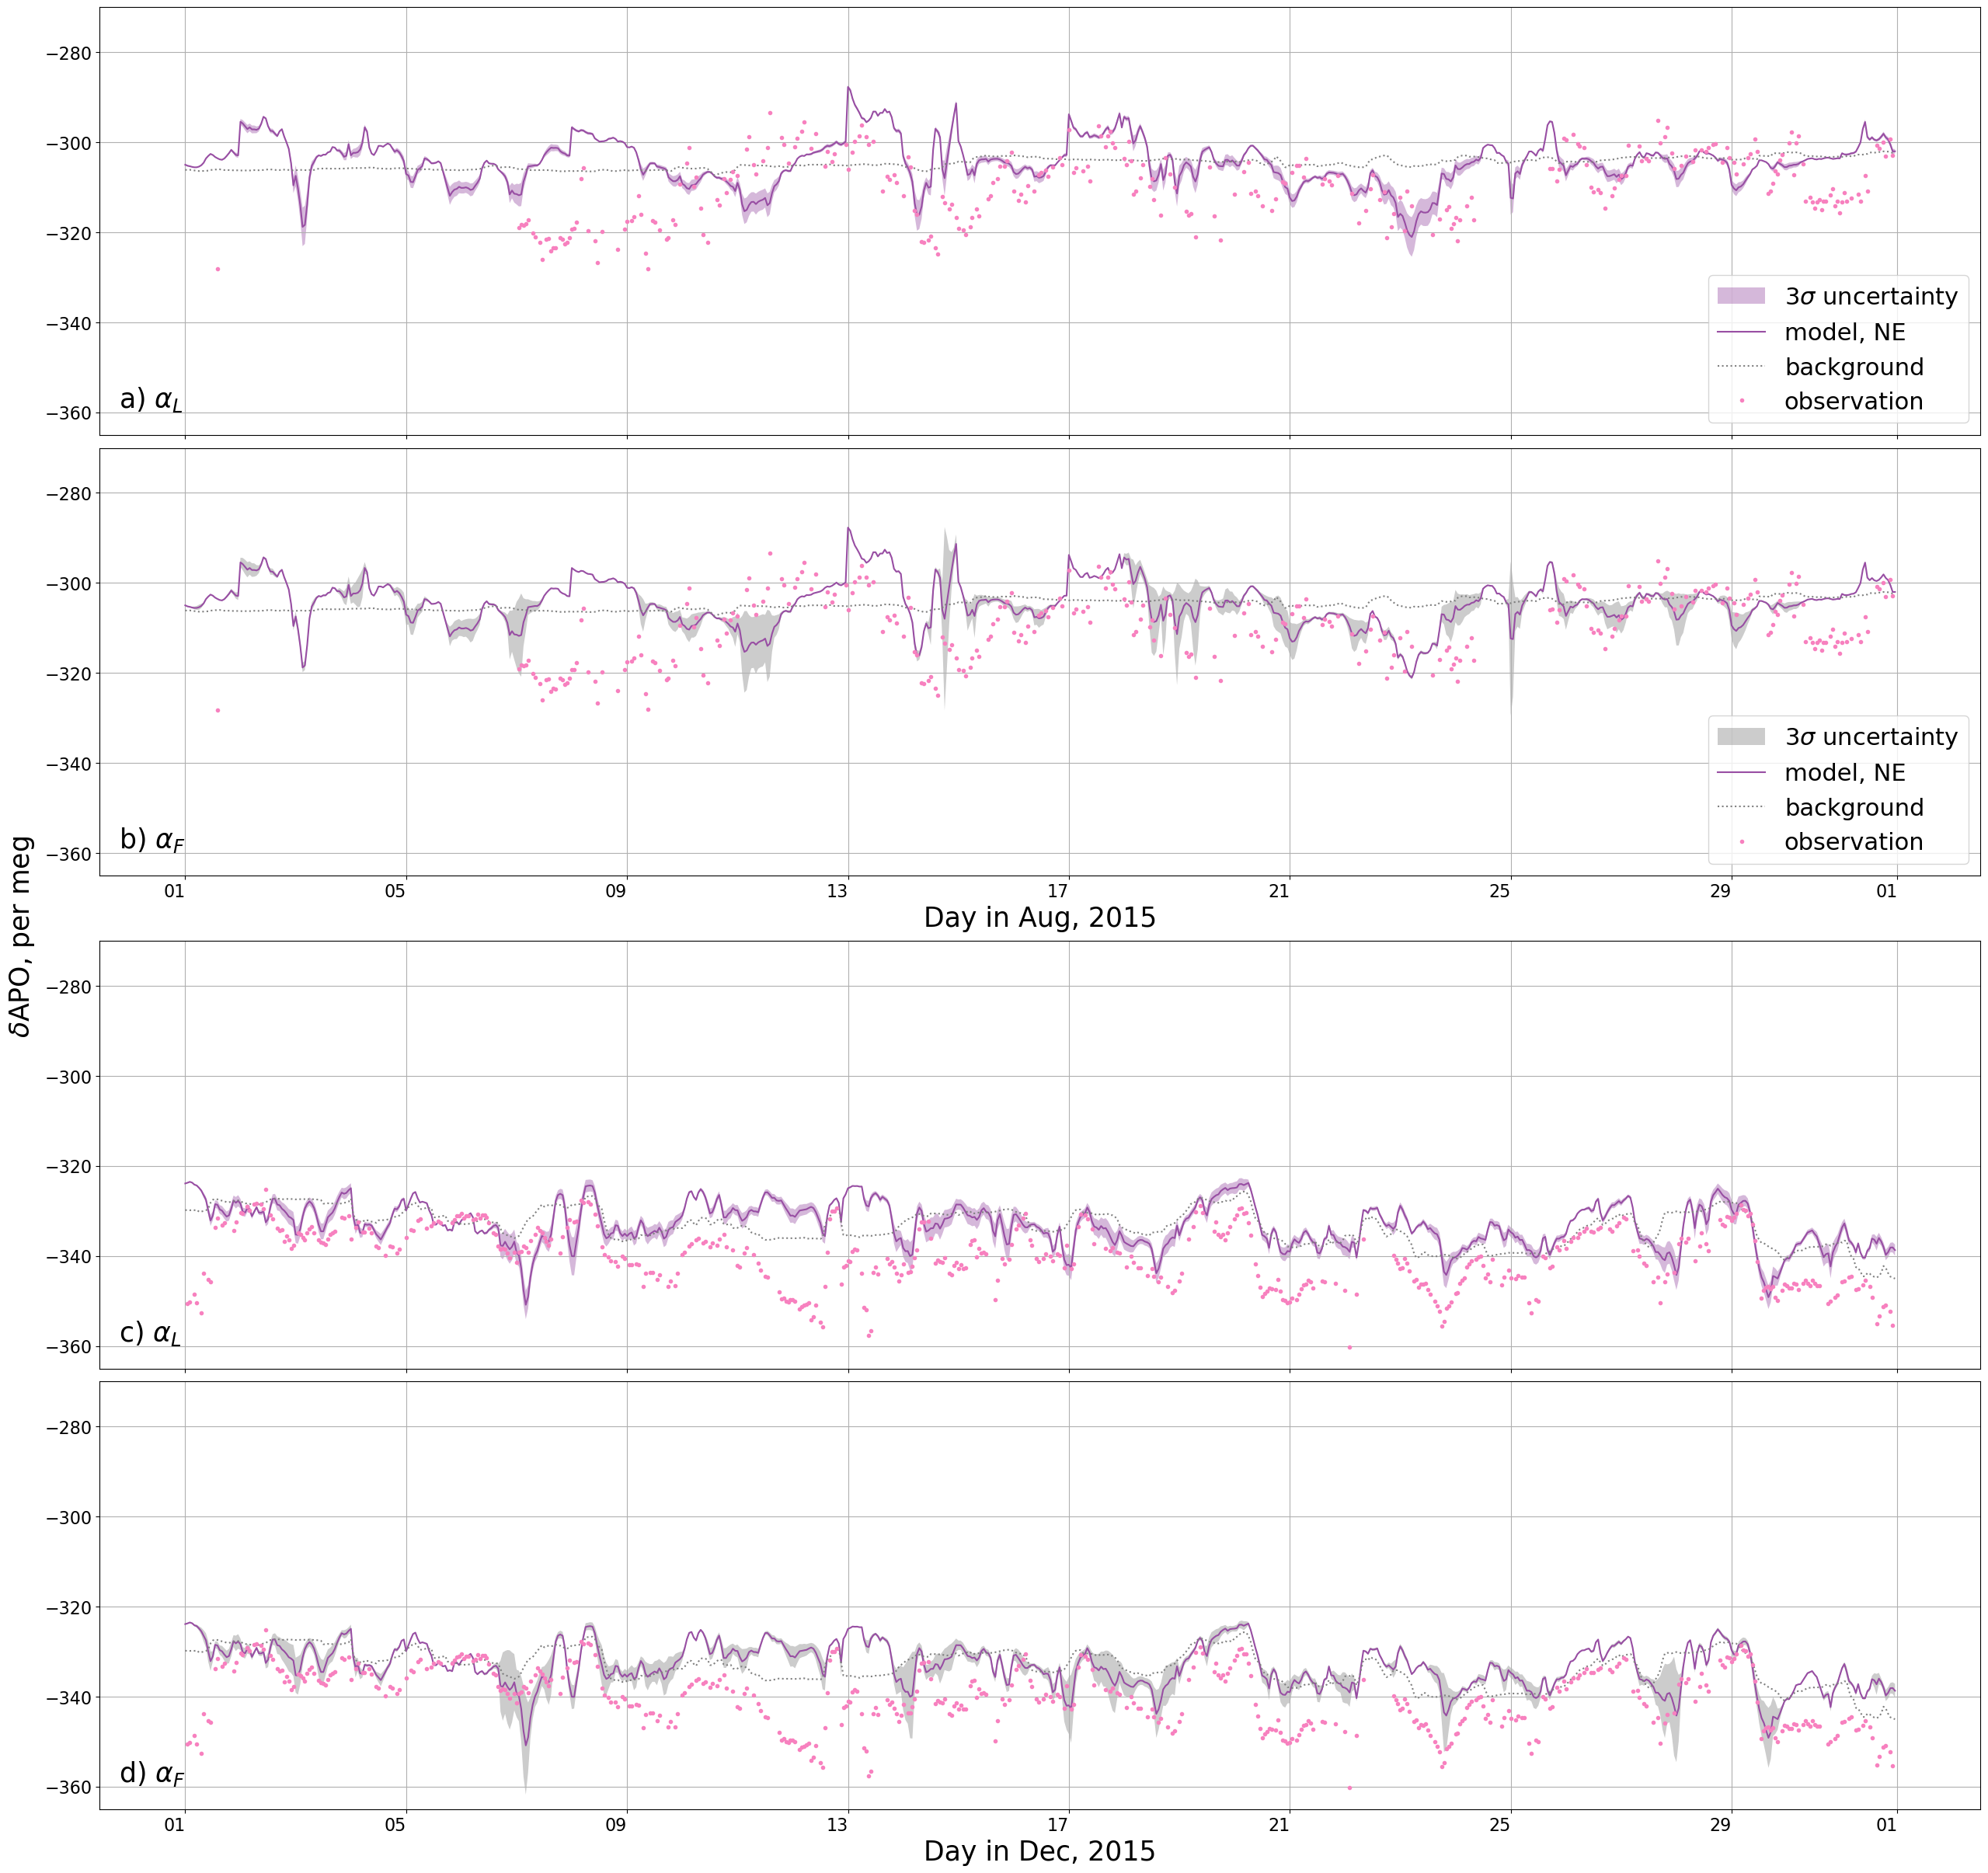

In [8]:
print(f'Plotting {sigma} sigma uncertainty')

apo_uncertainty_sigma = {month: {source: sigma * data_month[f'OR_{source}_{ocean_model}']
                                 for source in ['bio', 'ff']}
                         for month, data_month in data_unc.items()}

fig, axes = plt.subplots(nrows=2*len(months), ncols=1, figsize=(25, 12*len(months)), constrained_layout=True)

# plot uncertainty shading
colors = {'bio': apo_plot_info.colors[ocean_model], 'ff': 'grey'}

unc_plots = {month: {source: axes[ss+2*mm].fill_between(data_unc[month].time,
                                                        data_unc[month][f'model_{ocean_model}'] - apo_uncertainty_source,
                                                        data_unc[month][f'model_{ocean_model}'] + apo_uncertainty_source,
                                                        facecolor=colors[source],
                                                        alpha=0.4,
                                                        label = r'3$\sigma$ uncertainty')
                     for ss, (source, apo_uncertainty_source) in enumerate(apo_month.items())}
             for mm, (month, apo_month) in enumerate(apo_uncertainty_sigma.items())}
# plot timeseries
apo_plots = {month: [data_month[f'model_{ocean_model}'].plot(ax=axes[aa+mm*2], color=apo_plot_info.colors[ocean_model],
                                                             label=f'model, {apo_plot_info.model_names[ocean_model]}')
                     for aa in range(2)]
             for mm, (month, data_month) in enumerate(data_unc.items())}
bkg_plot = {month: [ts_month.apo_adjusted_bc.plot(ax=axes[aa+mm*2], color='grey', ls=':', label='background')
                    for aa in range(2)]
            for mm, (month, ts_month) in enumerate(ts_data.items())}
obs_plots = {month: [apo_month[site][0].mf.plot(ax=axes[aa+mm*2], color=apo_plot_info.colors['obs'], label='observation', marker='.', ls='none')
                     if len(apo_month)>0 else None
                     for aa in range(2)]
             for mm, (month, apo_month) in enumerate(apo_obs.items())}

# format the axes
grid = [ax.grid() for ax in axes]               # add grid
xlab = [ax.set_xlabel('') for ax in axes]       # remove xlabels
ylab = [ax.set_ylabel('', fontsize=fontsize+2) for ax in axes]          # remove ylabels
ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=25) # add combines ylabel
ylim = [ax.set_ylim(-365, -270) for ax in axes]
# ylim = [axes[ii].set_ylim(-365, -320) for ii in [2, 3]]
labels = [axes[aa].text(0.01, 0.05, f'{chr(97+aa)}) {alpha}', va='bottom', transform=axes[aa].transAxes, fontsize=25)
          for aa, alpha in enumerate([r'$\alpha_L$', r'$\alpha_F$']*2)]         # label the gas species on the axes
legend = [axes[ii].legend(loc='lower right', fontsize=22) for ii in range(2)]

if len(months)>1:
        xlabel = [axes[mm*2+1].set_xlabel(f'Day in {apo_plot_info.month_names[month]}, {year}', fontsize=25)
                  for mm, month in enumerate(months)]
        myFmt = mdates.DateFormatter('%d')
        [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
        ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
#        text = [axes[mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm].transAxes, va='top', fontsize=20)
#                for mm, month in enumerate(sorted((months*2)))]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]
       
ticks = [ax.tick_params(labelsize=fontsize) for ax in axes]     # change tick label fontsize
tick_labels = [axes[ii].xaxis.set_ticklabels([]) for ii in [i for i in range(0, len(axes))[0%2::2]]]    # remove repeated tick labels

# save the figure
out_date_str = '-'.join([f'{year}{str(month).zfill(2)}' for month in months])
filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'Sensitivity', f'APO_timeseries_OR_sensitivity_{sigma}sigma_{out_date_str}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)

## Combine the OR sensitivities

In [8]:
apo_uncertainty_total = {month: np.sqrt(unc_month.OR_bio_nemo**2 + unc_month.OR_ff_nemo**2)
                         for month, unc_month in data_unc.items()}

### Plot the overal OR sensitivity

Plotting 3 sigma uncertainty
Saving to /user/work/vf20487/Figures/Timeseries/Sensitivity/APO_timeseries_ORboth_sensitivity_3sigma_201508-201512.png


TypeError: got an unexpected keyword argument 'pad'

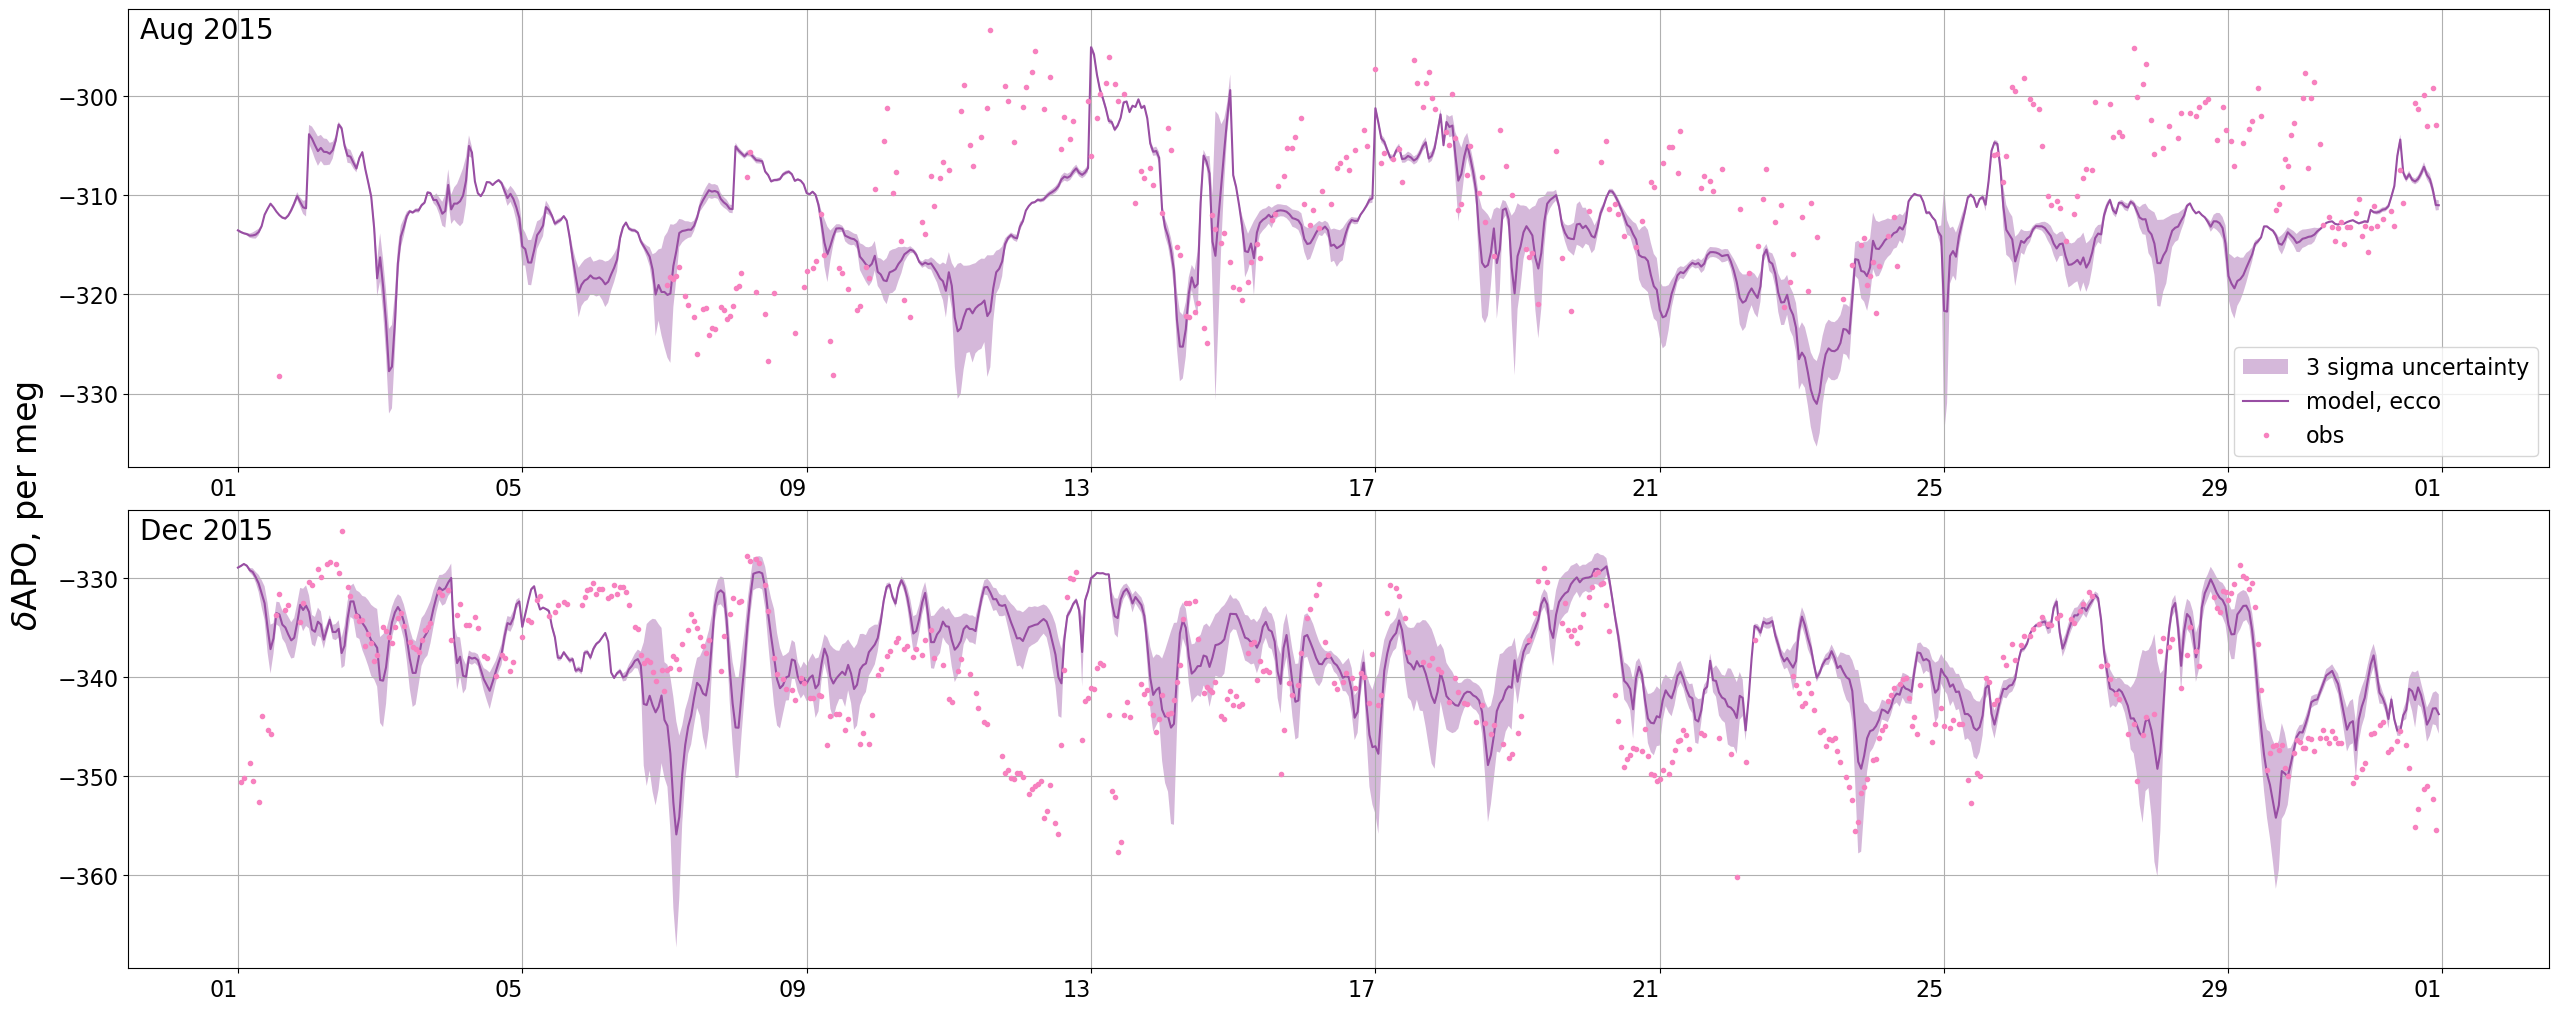

In [9]:
print(f'Plotting {sigma} sigma uncertainty')

apo_uncertainty_sigma = {month: sigma * unc_month
                         for month,unc_month in apo_uncertainty_total.items()}

fig, axes = plt.subplots(nrows=len(months), ncols=1, figsize=(25, 5*len(months)), constrained_layout=True)

unc_plot = {month: axes[mm].fill_between(data_unc[month].time,
                                         data_unc[month][f'model_{ocean_model}'] - apo_uncertainty_month,
                                         data_unc[month][f'model_{ocean_model}'] + apo_uncertainty_month,
                                         facecolor=apo_plot_info.colors[ocean_model],
                                         alpha=0.4,
                                         label=f'{sigma} sigma uncertainty')
            for mm, (month, apo_uncertainty_month) in enumerate(apo_uncertainty_sigma.items())}
            
apo_plot = {month: unc_month[f'model_{ocean_model}'].plot(ax=axes[mm], color=apo_plot_info.colors[ocean_model], label='model, ecco')
            for mm, (month, unc_month) in enumerate(data_unc.items())}
apo_obs_plot = [apo_obs[month][site][0]['mf'].plot(ax=axes[mm], color=apo_plot_info.colors['obs'], label='obs', marker='.', ls='none')
                for mm, month in enumerate(months)]

if len(months)>1:
       myFmt = mdates.DateFormatter('%d')
       [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
       ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
       text = [axes[mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm].transAxes, va='top', fontsize=20)
               for mm, month in enumerate(months)]
else:
       ticks = [ax.tick_params(labelsize=20) for ax in axes]

grid = [ax.grid() for ax in axes]
legend = axes[0].legend(loc='lower right', fontsize=fontsize)
xlab = [ax.set_xlabel('') for ax in axes]
ylab = [ax.set_ylabel('', fontsize=fontsize+2) for ax in axes]          # remove ylabels
ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=24) # add combines ylabel
ticks = [ax.tick_params(labelsize=fontsize) for ax in axes]

filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'Sensitivity', f'APO_timeseries_ORboth_sensitivity_{sigma}sigma_{out_date_str}.png')
print(f'Saving to {filename}')
fig.savefig(filename, bbox_inches='tight', pad=0)

Plotting 3 sigma uncertainty
Saving to /user/work/vf20487/Figures/Timeseries/Sensitivity/APO_timeseries_ORbio_sensitivity_3sigma_201508-201512.png
Saving to /user/work/vf20487/Figures/Timeseries/Sensitivity/APO_timeseries_ORff_sensitivity_3sigma_201508-201512.png


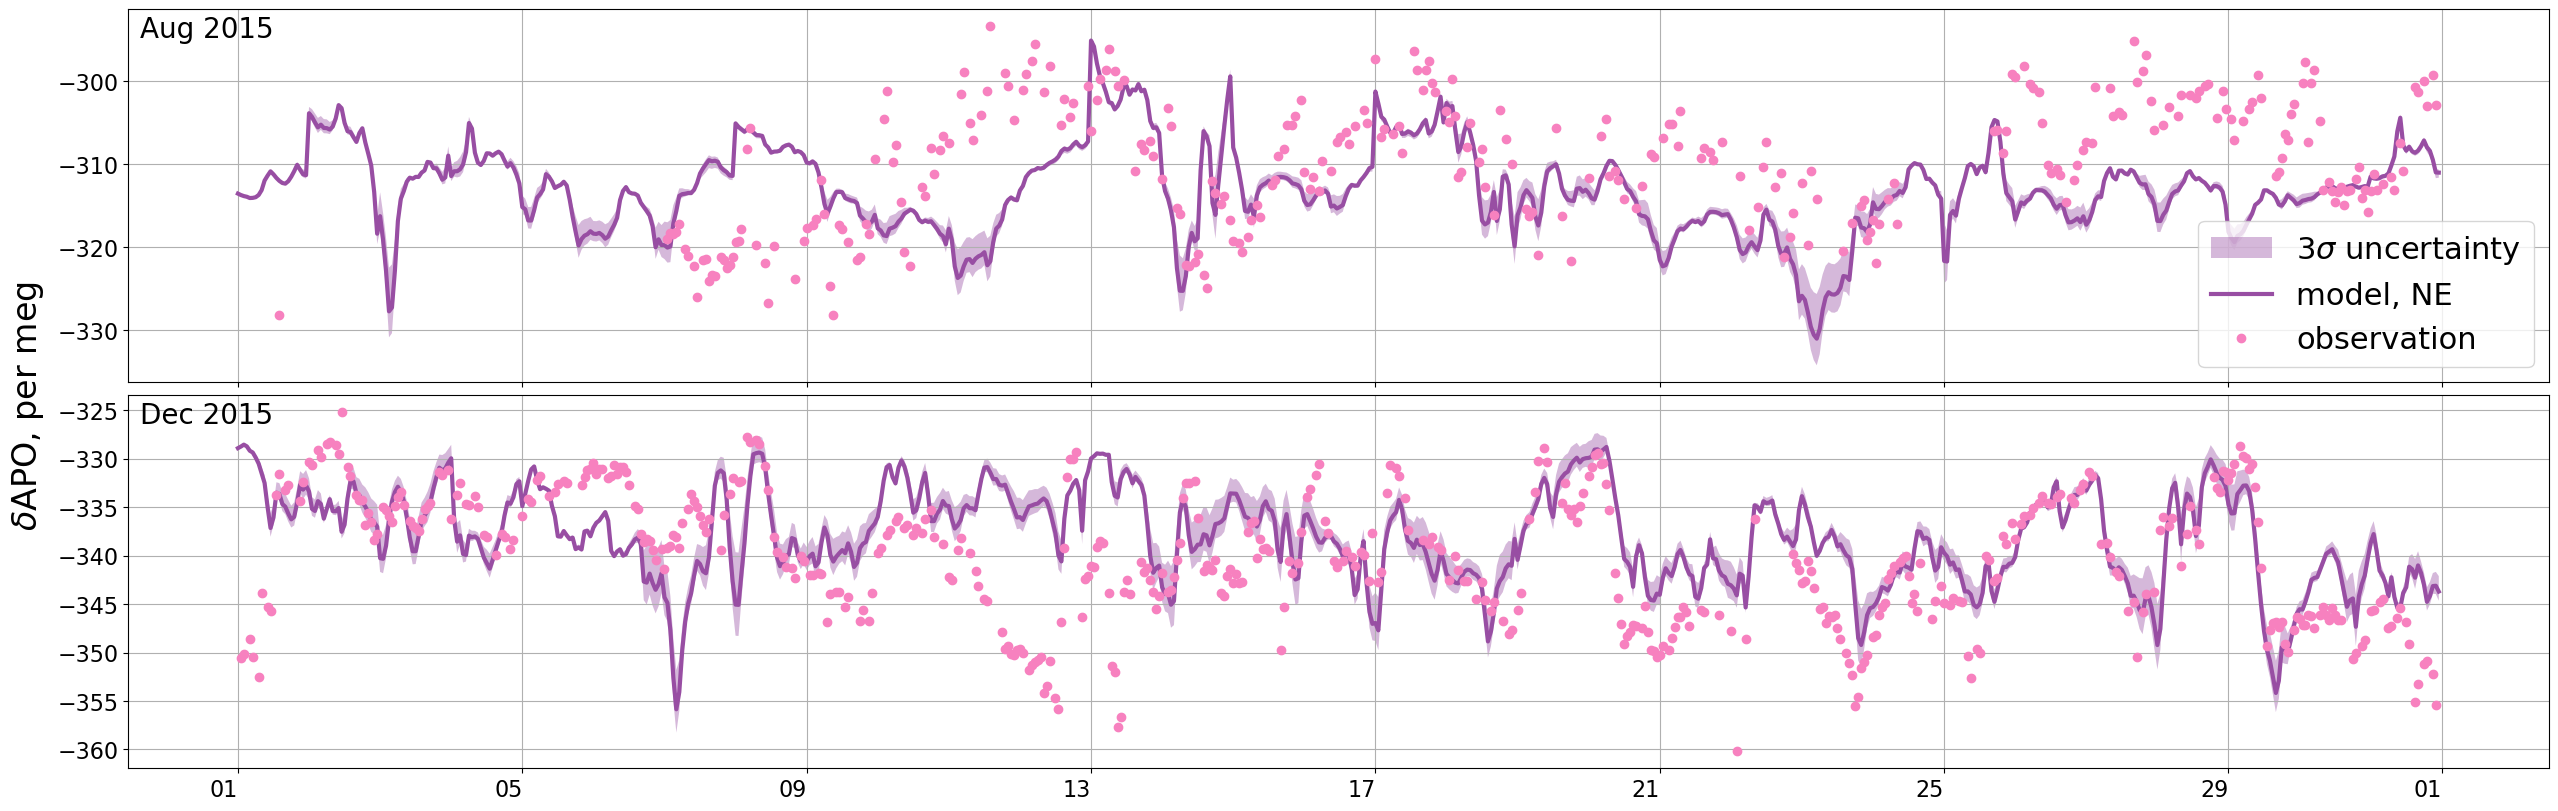

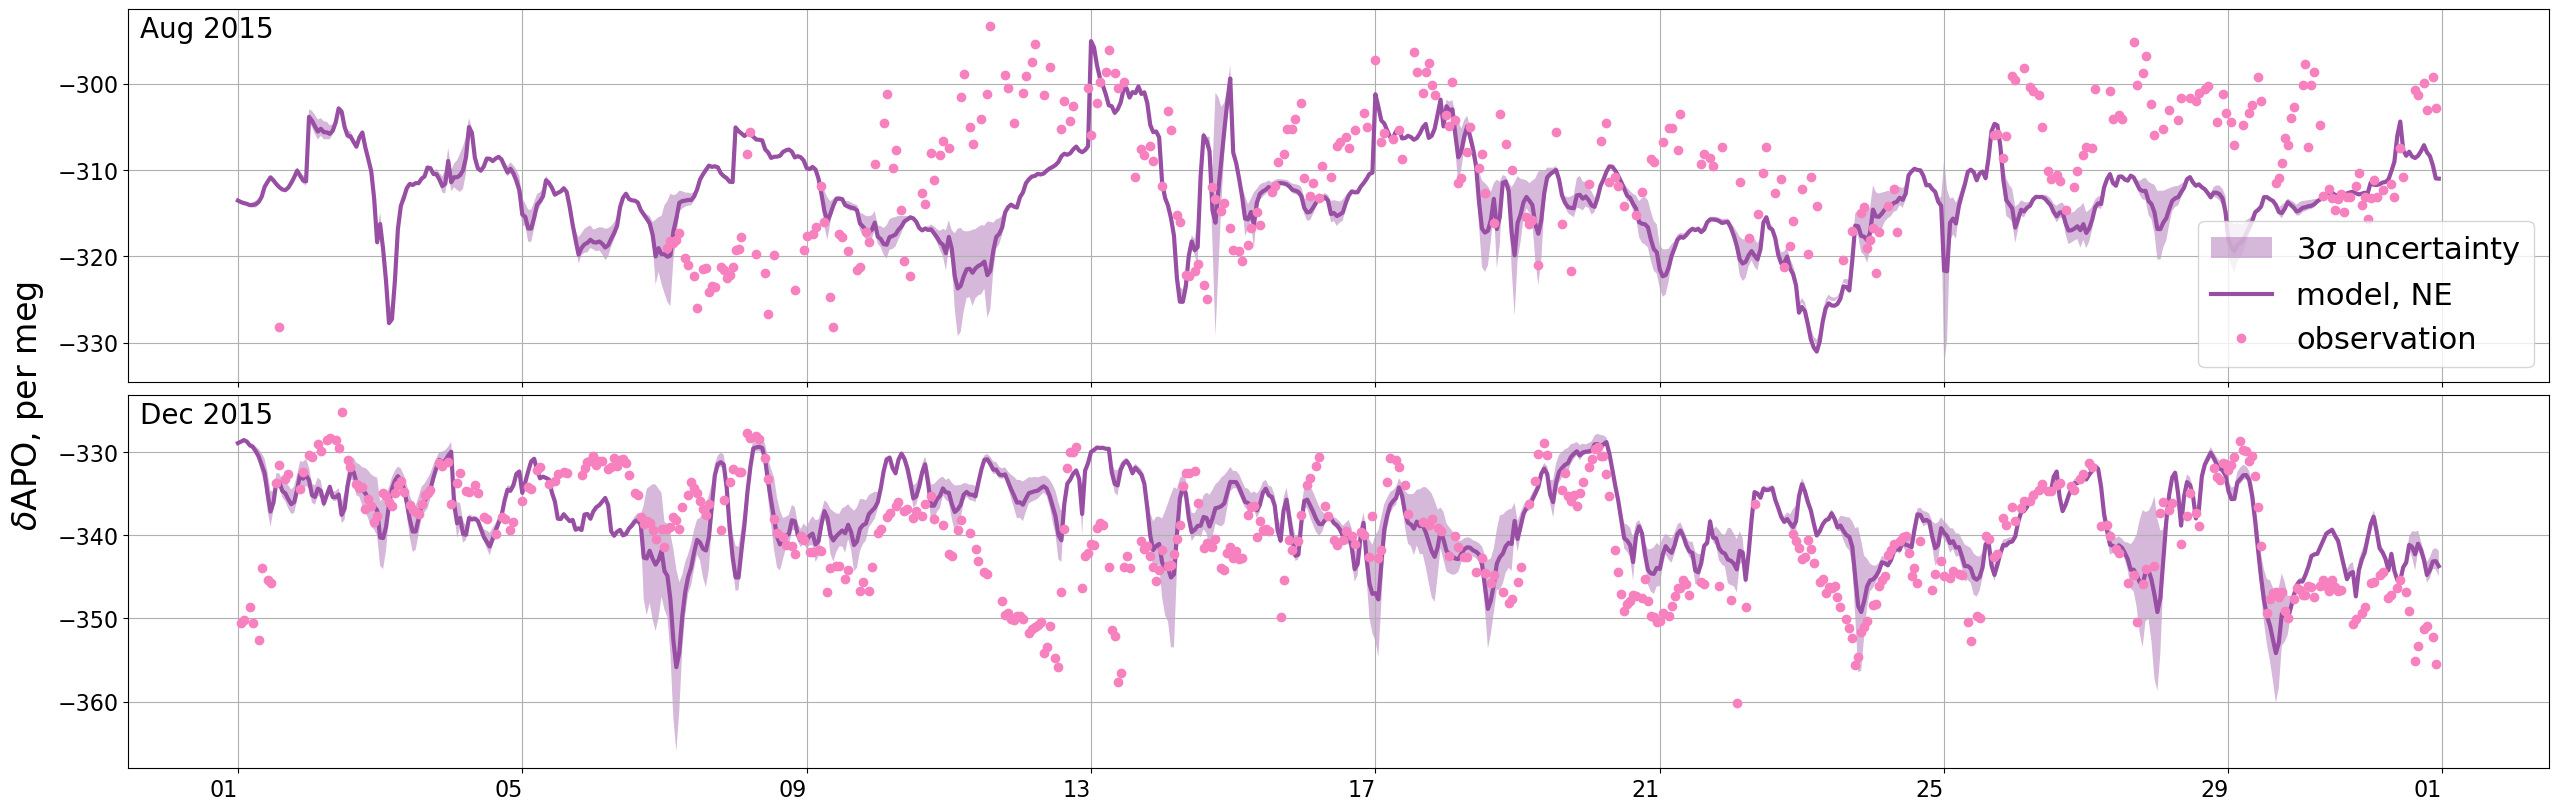

In [10]:
print(f'Plotting {sigma} sigma uncertainty')
apo_uncertainty_sigma = {month: {source: sigma * data_month[f'OR_{source}_{ocean_model}']
                                 for source in ['bio', 'ff']}
                         for month, data_month in data_unc.items()}

sources = {'bio': r'$\alpha_L$', 'ff': r'$\alpha_F$'}
for source, source_label in sources.items():
    fig, axes = plt.subplots(nrows=len(months), ncols=1, figsize=(25, 4*len(months)), constrained_layout=True)

    # plot uncertainty shading
    unc_plots = {month: axes[mm].fill_between(data_unc[month].time,
                                                    apo_total[month][ocean_model] - apo_month[source],
                                                    apo_total[month][ocean_model] + apo_month[source],
                                                    facecolor=apo_plot_info.colors[ocean_model],
                                                    alpha=0.4,
                                                    label = r'3$\sigma$ uncertainty')
                for mm, (month, apo_month) in enumerate(apo_uncertainty_sigma.items())}
    # plot timeseries
    apo_plots = {month: data_month[f'model_{ocean_model}'].plot(ax=axes[mm], color=apo_plot_info.colors[ocean_model],
                                                                   label=f'model, {apo_plot_info.model_names[ocean_model]}', lw=3)
                 for mm, (month, data_month) in enumerate(data_unc.items())}
    obs_plots = {month: apo_month[site][0].mf.plot(ax=axes[mm], color=apo_plot_info.colors['obs'], label='observation',
                                                   marker='o', ls='none', markersize=6)
                        if len(apo_month)>0 else None
                for mm, (month, apo_month) in enumerate(apo_obs.items())}

    if len(months)>1:
        myFmt = mdates.DateFormatter('%d')
        [ax.xaxis.set_major_formatter(myFmt) for ax in axes]
        ticks = [ax.tick_params(labelsize=20, labelrotation=0) for ax in axes]
        text = [axes[mm].text(0.005, 0.985, f'{apo_plot_info.month_names[month]} {year}', transform=axes[mm].transAxes, va='top', fontsize=20)
                for mm, month in enumerate(sorted((months)))]
    else:
        ticks = [ax.tick_params(labelsize=20) for ax in axes]

    # format the axes
    grid = [ax.grid() for ax in axes]               # add grid
    xlab = [ax.set_xlabel('') for ax in axes]       # remove xlabels
    ylab = [ax.set_ylabel('', fontsize=fontsize+2) for ax in axes]          # remove ylabels
    ylabel = fig.text(-0.01, 0.5, r'$\delta$APO, per meg', va='center', ha='center', rotation='vertical', fontsize=24) # add combines ylabel
    ticks = [ax.tick_params(labelsize=fontsize) for ax in axes]     # change tick label fontsize
    tick_labels = [axes[ii].xaxis.set_ticklabels([]) for ii in [i for i in range(0, len(axes))[0%2::2]]]    # remove repeated tick labels
    # labels = axes.text(0.01, 0.05, source_label, va='bottom', transform=axes.transAxes, fontsize=25)         # label the gas species on the axes
    legend = axes[0].legend(loc='lower right', fontsize=22)

    # save the figure
    out_date_str = '-'.join([f'{year}{str(month).zfill(2)}' for month in months])
    filename = os.path.join('/user', 'work', 'vf20487', 'Figures', 'Timeseries', 'Sensitivity', f'APO_timeseries_OR{source}_sensitivity_{sigma}sigma_{out_date_str}.png')
    print(f'Saving to {filename}')
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.4)